In [1]:
%load_ext autoreload
%autoreload 2

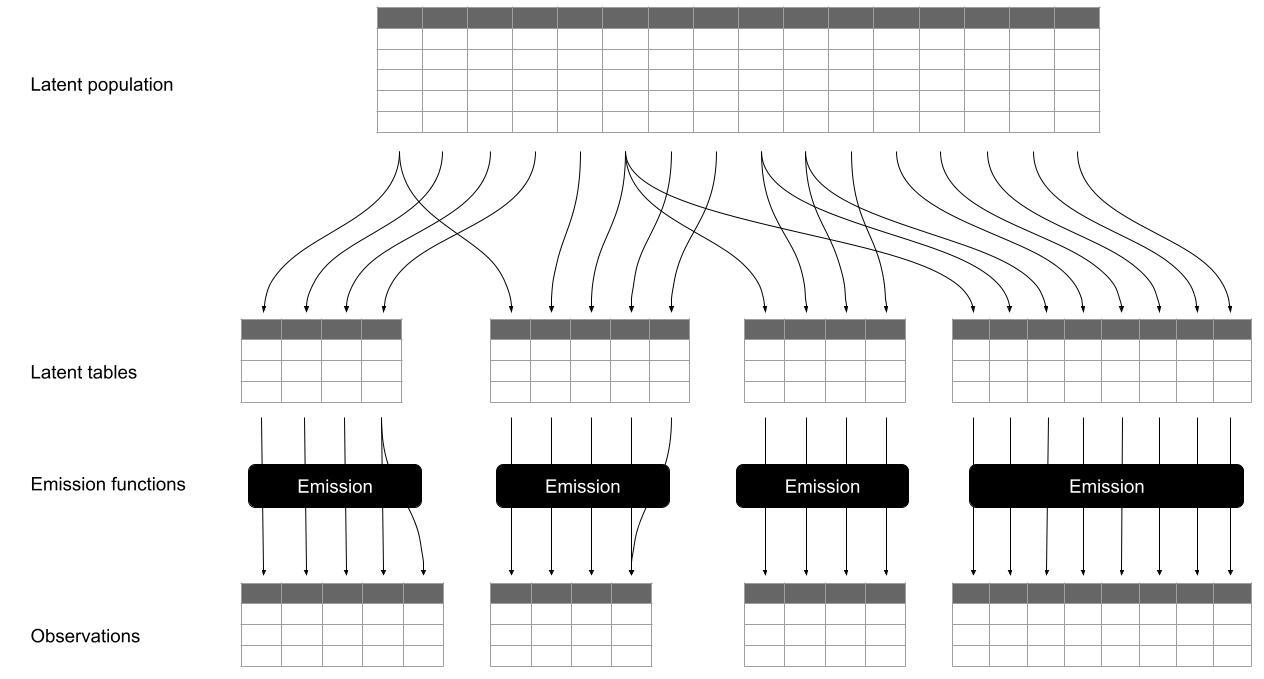

# Writing a generative model

In [2]:
import jax.numpy as jnp
import jax
import genjax
import polars as pl
import numpy as np
from itertools import product
from jax.scipy.special import logit
from genjax import static_gen_fn
from generative_join.modeling import (
    aggregate_mean,
    importance_sample,
    estimate_mu_std,
    make_conditions_dict,
    estimate_logprobs,
)

In [9]:
from tests.test_synthetic_data import gen_parametrized_z, component_params, component_logprobs, make_health_data
from generative_join.modeling import mixture_model

In [13]:
@static_gen_fn
def make_social_data(key, gen_z, gen_z_args, n_sample, n_importance_samples):
    # model for OI social connectedness data
    n_importance_samples = n_importance_samples.const

    conditions = product(
        [0, 1],
        [0, 1, 2, 3],
    )
    conditions = np.array([c for c in conditions])

    condition_names = ["attended_elite_college", "region"]
    keys = jax.random.split(key, len(conditions))

    trs, ws = jax.vmap(importance_sample, in_axes=(0, None, None, 0, None, None))(
        keys, gen_z, gen_z_args, conditions, condition_names, n_importance_samples
    )

    logprob_conditions = jax.vmap(estimate_logprobs)(ws)

    group_sizes = (
        genjax.multinomial(jnp.array(n_sample, float), logprob_conditions) @ "social_group_sizes"
    )
    mus, stds = jax.vmap(estimate_mu_std, in_axes=(0, 0, None))(
        trs, ws, "connected"
    )

    map_aggregate_mean = genjax.map_combinator(in_axes=(0, 0, 0))(aggregate_mean)
    means = map_aggregate_mean(mus, stds, group_sizes) @ "social_map_aggregate_mean"

    # make dictionary with high_income, male, region, mean(high_life_expectancy), and counts
    conditions_dict = make_conditions_dict(conditions, condition_names)
    conditions_dict["mean(connected)"] = means
    conditions_dict["count"] = group_sizes

    return conditions_dict

In [16]:
@static_gen_fn
def make_politics_data(gen_z, gen_z_args, n_sample):
    # model for cces
    map_array = jnp.ones(n_sample.const)
    map_gen_z = genjax.map_combinator(in_axes=(None, None, 0))(aux_gen_z)
    sample_dict = map_gen_z(gen_z, gen_z_args, map_array) @ "politics_samples"

    return {k: v for k, v in sample_dict.items() if k in ["male", "region", "supports_medicare", "vote_republican"]}
    
@static_gen_fn
def aux_gen_z(gen_z, gen_z_args, _):
    # hack while the repeat combinator in genjax remains buggy
    return gen_z.inline(*gen_z_args)

# Running the generative model forward

In [10]:
key = jax.random.PRNGKey(0)
keys = jax.random.split(key, 5)
n_sample = 1000
n_importance_samples = 10000
args = (component_logprobs, component_params, gen_parametrized_z)

In [11]:
health_tr = make_health_data.simulate(keys[0], (keys[1], mixture_model, args, n_sample, genjax.Pytree.const(n_importance_samples)))

In [14]:
social_tr = make_social_data.simulate(keys[2], (keys[3], mixture_model, args, n_sample, genjax.Pytree.const(n_importance_samples)))

In [17]:
politics_tr = make_politics_data.simulate(keys[4], (mixture_model, args, genjax.Pytree.const(n_sample)))

In [18]:
def trace_to_df(tr):
    tr_dict = {k: np.array(v) for k, v in tr.get_retval().items()}
    return pl.from_dict(tr_dict)

In [19]:
politics_df = trace_to_df(politics_tr)

In [20]:
health_df = trace_to_df(health_tr)

In [21]:
social_df = trace_to_df(social_tr)

In [22]:
politics_df.describe()

statistic,male,region,supports_medicare,vote_republican
str,f64,f64,f64,f64
"""count""",1000.0,1000.0,1000.0,1000.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",0.45,1.053,0.372,0.406
"""std""",0.497743,1.154783,0.48358,0.49133
"""min""",0.0,0.0,0.0,0.0
"""25%""",0.0,0.0,0.0,0.0
"""50%""",0.0,1.0,0.0,0.0
"""75%""",1.0,2.0,1.0,1.0
"""max""",1.0,3.0,1.0,1.0


# Solving a simple inference problem

As a first example, we'll solve a really simple inference problem
- We'll start by placing a simple prior on z, as a mixture

In [19]:
@static_gen_fn
def gen_z_prior():
    p = genjax.uniform() @ "p"

    @static_gen_fn
    def parametrized_gen_z():
        model_choice = genjax.bernoulli(logit(p)) @ "model"
        model_choice = jnp.array(model_choice, dtype=int)
        z = switch(model_choice) @ "z"
        return z

    return parametrized_gen_z

In [26]:
@static_gen_fn
def model(key):
    keys = jax.random.split(key, 2)

    p = genjax.uniform() @ "p"
    component_logprobs = jnp.log(jnp.array([1-p, p]))

    args = (component_logprobs, component_params, gen_parametrized_z)
    # fix: if I don't inline the calls to health/social data, I get an UnexpectedTracer error when doing
    # IS on model. 
    health_data = make_health_data.inline(keys[0], mixture_model, args, n_sample, genjax.Pytree.const(n_importance_samples))
    social_data = make_social_data.inline(keys[1], mixture_model, args, n_sample, genjax.Pytree.const(n_importance_samples))
    politics_data = make_politics_data.inline(mixture_model, args, genjax.Pytree.const(n_sample))

    return health_data, social_data, politics_data

In [24]:
obs, _ = health_tr.get_choices().merge(social_tr.get_choices())
obs, _ = obs.merge(politics_tr.get_choices())

In [27]:
key = jax.random.PRNGKey(1234)
keys = jax.random.split(key, 101)

# question I should ask mccoy---how can I ergonomically vmap over the second key here?
trs, ws = jax.vmap(model.importance, in_axes=(0, None, None))(keys[1:], obs, (keys[0],))
# tr, w = model.importance(keys[1], obs, (keys[0],))

In [ ]:
probs = np.exp(ws - np.max(ws))
probs /= np.sum(probs)
plot_df = pl.from_dict({"p": trs["p"], "prob": probs})

In [ ]:
import seaborn as sns

In [ ]:
sns.scatterplot(data=plot_df, x="p", y="prob")